In [9]:
# Bayesian inference problem for probability of survival for Sepsis patients
# look at SOFA scores to determine uncertainty
# Maximum SOFA score reached during trajectory and whether there was death or not
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import math

In [4]:
data = pd.read_csv("../data/mimicdata_MK.csv")

In [5]:
# y = a(1 - r)^x
# a = 1 and let r be unknown
# x = max. SOFA score in a trjectory
curr_sofa = -1
curr_mort = -1
dct = {}
# visualize data likelihood
for i in range(len(data) - 1):
    curr_state = data.iloc[i]
    next_state = data.iloc[i+1]
    
    sofa = curr_state['SOFA']
    mort = curr_state['died_in_hosp']
    icu_curr = curr_state['icustayid']
    icu_next = next_state['icustayid']
    
    if (sofa > curr_sofa):
        curr_sofa = sofa
        curr_mort = mort
        
    if (icu_curr != icu_next):
        # add statistics. (total, mortality)
        if curr_sofa not in dct:
            dct[curr_sofa] = (0,0)
        #update number
        total_count = dct[curr_sofa][0]
        total_mort = dct[curr_sofa][1]
        
        if (curr_mort):
            total_mort += 1
            
        update = (total_count + 1, total_mort)
        dct[curr_sofa] = update
        
        curr_sofa = -1
        curr_mort = -1

if curr_sofa not in dct:
    dct[curr_sofa] = (0,0)    
total_count = dct[curr_sofa][0]
total_mort = dct[curr_sofa][1]
total_mort = dct[curr_sofa][1]
if (curr_mort):
    total_mort += 1
            
update = (total_count + 1, total_mort)
dct[curr_sofa] = update




<BarContainer object of 24 artists>

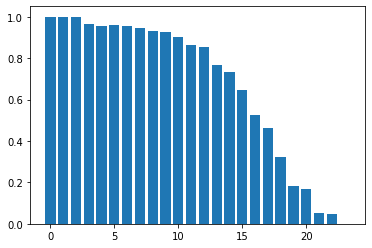

In [6]:
# plot data likelihood
x = [i for i in range(24)]
y = []
for key in sorted(dct.keys()):
    count, mort = dct[key]
    survive = 1 - (mort / count)
    y.append(survive)
plt.bar(x,y)

In [15]:
# calculate logistic likelihood
def logistic_likelihood(x, alpha, beta):
    return (1 / (1 + np.exp(beta*x + alpha)))

# returns the log factorial
def nCr(n,r):
    lgamma = math.lgamma
    return lgamma(n+1) - lgamma(r+1) - lgamma(n+1-r)
    #return f(n) / f(r) / f(n-r)

def log_likelihood(dct, alpha, beta):
    log_likelihood = 0
    for key in sorted(dct.keys()):
        count, mort = dct[key]
        survival = count - mort
        p = logistic_likelihood(key , alpha, beta)
        # convert to binomial likelihood
        # (p)^y(1-p)^(1-y)
        # log (nCr) + r log p + (count - r) log (1 - p)
        log_likelihood += nCr(count, survival) + (survival * np.log(p)) + mort * np.log(1 - p)
    return log_likelihood

In [16]:
# logistic regression model
# p(survive) = 1/(1+ e^(B(sofa) + a))
cov = [[1,0], [0,1]] # for sampling from symmetric multivariate normal
mean = [0,0]
#alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
#beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)

#initialize x(0). Sample from the prior distribution of alpha and beta
#alpha = np.random.normal()
x_init = np.random.multivariate_normal(mean, cov) # x_init = [alpha, beta]
max_iters = 100000
cov_q = [[0.05, 0], [0, 0.05]]
x_hist = []
for i in range(max_iters):
    x_prop = x_init + np.random.multivariate_normal(mean, cov_q)
    
    alpha_prop = x_prop[0]
    beta_prop = x_prop[1]
    
    alpha_prev = x_init[0]
    beta_prev = x_init[1]
    
    
    prior_alpha_prop = scipy.stats.norm(0, 1).pdf(alpha_prop)
    prior_beta_prop = scipy.stats.norm(0, 1).pdf(beta_prop)
    
    prior_alpha_prev = scipy.stats.norm(0, 1).pdf(alpha_prev)
    prior_beta_prev = scipy.stats.norm(0, 1).pdf(beta_prev)
    
    likelihood_prev = log_likelihood(dct, alpha_prev, beta_prev)
    likelihood_prop = log_likelihood(dct, alpha_prop, beta_prop)
    
    #ratio = (likelihood_prop * prior_alpha_prop * prior_beta_prop) / (likelihood_prev * prior_alpha_prev * prior_beta_prev)
    
    accept_log_prob = min(0, likelihood_prop - likelihood_prev)
    #print(accept_prob)
    
    rand = np.log(np.random.uniform(0.0, 1.0))
    
    if accept_log_prob > rand:
        x_init = x_prop
    
    # store proposals
    x_hist.append(x_init) 

(array([ 2.46783805,  1.80919208,  4.26035555,  4.65220821,  2.36779056,
        12.7227056 , 10.83014062, 21.11002005, 23.51949706, 47.07234328,
        30.53949582, 29.54735823, 41.3196127 , 76.75309816, 61.82934781,
        73.00131735, 65.58112863, 42.89536064, 34.5914191 , 25.37037559,
        21.00997256, 30.13930587, 11.41375096, 22.53569676, 22.92754942,
        12.71436831,  7.72866848,  0.83372907,  7.0783598 ,  1.73415647]),
 array([0.29366509, 0.29499779, 0.2963305 , 0.2976632 , 0.2989959 ,
        0.3003286 , 0.3016613 , 0.302994  , 0.3043267 , 0.3056594 ,
        0.3069921 , 0.3083248 , 0.3096575 , 0.3109902 , 0.3123229 ,
        0.3136556 , 0.3149883 , 0.316321  , 0.3176537 , 0.3189864 ,
        0.3203191 , 0.3216518 , 0.3229845 , 0.3243172 , 0.32564991,
        0.32698261, 0.32831531, 0.32964801, 0.33098071, 0.33231341,
        0.33364611]),
 <a list of 1 Patch objects>)

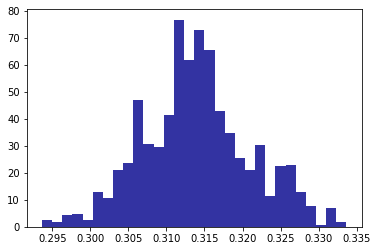

In [17]:
alpha_samples = list(map(lambda x: x[0], x_hist))[10000:]
beta_samples = list(map(lambda x: x[1], x_hist))[10000:]

plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)

(array([6.46985552e-03, 5.02707774e-01, 1.24868211e-01, 3.60370952e-01,
        2.76909816e-01, 9.28424267e-01, 1.84714375e+00, 1.34314201e+00,
        1.60064226e+00, 1.75591879e+00, 1.39942975e+00, 2.65522870e+00,
        3.82691954e+00, 4.06889214e+00, 4.92356005e+00, 6.73382562e+00,
        6.97062233e+00, 3.99707674e+00, 3.86832661e+00, 2.47924863e+00,
        1.62069881e+00, 2.92825661e+00, 1.45507051e+00, 1.15810414e+00,
        3.20257848e-01, 2.86614599e-01, 4.34774291e-01, 1.81802940e-01,
        1.94095666e-02, 1.53982561e-01]),
 array([-5.53660532, -5.51943166, -5.50225799, -5.48508433, -5.46791067,
        -5.45073701, -5.43356335, -5.41638968, -5.39921602, -5.38204236,
        -5.3648687 , -5.34769504, -5.33052137, -5.31334771, -5.29617405,
        -5.27900039, -5.26182673, -5.24465307, -5.2274794 , -5.21030574,
        -5.19313208, -5.17595842, -5.15878476, -5.14161109, -5.12443743,
        -5.10726377, -5.09009011, -5.07291645, -5.05574278, -5.03856912,
        -5.02139

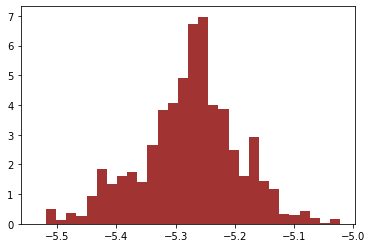

In [18]:
plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True)


In [20]:
alpha_est = np.mean(alpha_samples)
beta_est = np.mean(beta_samples)

<BarContainer object of 24 artists>

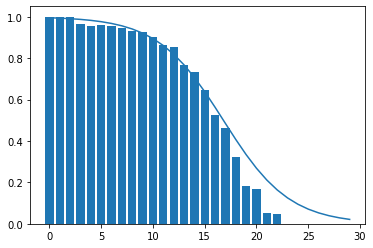

In [25]:
Y = [logistic_likelihood(i, alpha_est, beta_est) for i in range(30)]
plt.plot(Y)
plt.bar(x,y)